In [96]:
# Init functions
import tensorflow as tf
from pathlib import Path

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from dermclass_models.image.config import ImageConfig
import cv2
config = ImageConfig
import matplotlib.pyplot as plt

Num GPUs: 1


In [98]:
# def format_label(label):
#     string_label = label_info.int2str(label)
#     return string_label.split("-")[1]


# label_info = ds_info.features["label"]
# for i, (image, label) in enumerate(ds_train.take(9)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image.numpy().astype("uint8"))
#     plt.title("{}".format(format_label(label)))
#     plt.axis("off")

In [106]:
def get_avg_img_size(path: Path = config.DATA_PATH):
    height_list = []
    width_list = []
    for subclass_dir in path.iterdir():
        for img_path in subclass_dir.iterdir():
            img = cv2.imread(str(img_path))
            height, width, _ = img.shape
            height_list.append(height)
            width_list.append(width)
    mean_height = int(sum(height_list) / len(height_list))
    mean_width = int(sum(width_list) / len(width_list))
        
    return mean_height, mean_width

avg_size = get_avg_img_size()
img_shape = avg_size + (3,)
print(avg_size)

(473, 561)


In [113]:
def get_efficcient_net_and_size(img_size: int):
    """https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/"""
    
    img_mean = (img_size[0] + img_size[1]) / 2
    if img_mean <= 492:
        img_size = (456, 456)
        model = tf.keras.applications.EfficientNetB5
        
    if 492 < img_mean <= 564:
        img_size = (528, 528)
        model = tf.keras.applications.EfficientNetB6
        
    if 564 < img_mean:
        img_size = (600, 600)
        model = tf.keras.applications.EfficientNetB7
    
    return img_size, model

In [114]:
img_size, model_obj = get_efficcient_net_and_size(img_size=avg_size)

In [128]:
def load_dataset(image_size, batch_size=config.BATCH_SIZE):
    batch_size=3
    
    
    train_dataset = (tf.keras.preprocessing
                     .image_dataset_from_directory(config.DATA_PATH,
                                                   validation_split=config.TEST_SIZE,
                                                   batch_size=batch_size,
                                                   subset="training",
                                                   seed=config.SEED,
                                                   image_size=image_size,
                                                   shuffle=True))    
    validation_dataset = (tf.keras.preprocessing
               .image_dataset_from_directory(config.DATA_PATH,
                                             validation_split=config.TEST_SIZE,
                                             batch_size=batch_size,
                                             subset="validation",
                                             seed=config.SEED,
                                             image_size=image_size,
                                             shuffle=True))
    
    val_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(val_batches // 5)
    validation_dataset = validation_dataset.skip(val_batches // 5)
    
    print("xxxxxxxxxxx")
    print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
    
    return train_dataset, validation_dataset, test_dataset

train_dataset, validation_dataset, test_dataset = load_dataset(img_size)

Found 71 files belonging to 3 classes.
Using 57 files for training.
Found 71 files belonging to 3 classes.
Using 14 files for validation.
xxxxxxxxxxx
Number of train batches: 19
Number of validation batches: 4
Number of test batches: 1


In [129]:
# for image, label in ds_train.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         aug_img = img_augmentation(tf.expand_dims(image, axis=0))
#         plt.imshow(aug_img[0].numpy().astype("uint8"))
#         plt.title("{}".format(format_label(label)))
#         plt.axis("off")

In [130]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [131]:
def _get_data_augmentation(rescale=False):
    layers = [
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1)]

    if rescale:
        layers.append(tf.keras.layers.experimental.preprocessing.Rescaling(1/225))
        
    data_augmentation = tf.keras.Sequential(layers)
    
    return data_augmentation

In [132]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(3, 16, 16, 2304)


In [133]:
# change for stronger regularization drop_connect_rate=0.4
base_model = model_obj(include_top=False, weights='imagenet', classes=3)
base_model.trainable = False

In [140]:
base_model.summary()

Model: "efficientnetb6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         multiple             0           input_10[0][0]                   
__________________________________________________________________________________________________
normalization_5 (Normalization) multiple             7           rescaling_6[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   multiple             0           normalization_5[0][0]            
_____________________________________________________________________________________

In [141]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(3, 2304)


In [142]:
prediction_layer = tf.keras.layers.Dense(3, "softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(3, 3)


In [143]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [164]:
model = tf.keras.Sequential([inputs,
                              data_augmentation,
                              base_model,
                              global_average_layer,
                              tf.keras.layers.Dropout(0.2),
                              prediction_layer
                             ])

In [165]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [166]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 1s 190ms/step - loss: 1.1504 - accuracy: 0.6364


In [167]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.15
initial accuracy: 0.64


In [168]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [169]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                   callbacks=[callback])

Epoch 1/10
19/19 [==============================] - 6s 316ms/step - loss: 1.9709 - accuracy: 0.4561 - val_loss: 0.9044 - val_accuracy: 0.6364
Epoch 2/10
19/19 [==============================] - 6s 309ms/step - loss: 1.8168 - accuracy: 0.4561 - val_loss: 1.5488 - val_accuracy: 0.6364
Epoch 3/10
19/19 [==============================] - 6s 309ms/step - loss: 2.4370 - accuracy: 0.3684 - val_loss: 2.2057 - val_accuracy: 0.6364
Epoch 4/10
19/19 [==============================] - 6s 308ms/step - loss: 2.3076 - accuracy: 0.4737 - val_loss: 1.7756 - val_accuracy: 0.6364


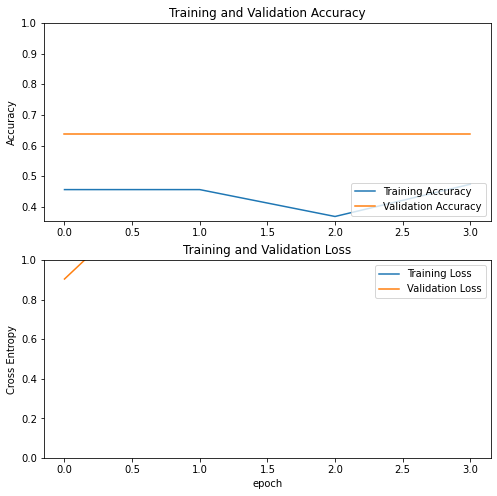

In [170]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [171]:
loss1, accuracy1 = model.evaluate(test_dataset)

1/1 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 1.0000


In [172]:
accuracy1

1.0

In [ ]:
model.save(".")